# MLP로 중위 주택가격 예측하기
*Welcome to Machine Learning Housing Corp.! 캘리포니아주의 주택 가격을 예측해봅시다.*<br>
**런타임 유형을 GPU로 설정해주세요.**

by uramoon@kw.ac.kr<br>
원본 출처: https://github.com/ageron/handson-ml2 (<a href=https://github.com/ageron/handson-ml2/blob/master/LICENSE>Apache 2.0 License</a>)



MLP (Multi-Layer Perceptron)는 퍼셉트론으로 구성된 층 (layer)을 여러 개 갖고 있는 인공신경망입니다. 단일 퍼셉트론과는 달리 MLP는 은닉층이 하나 이상 있으면 은닉층에 충분한 유닛 (퍼셉트론)을 공급하는 경우 어떠한 함수도 만들어낼 수 있습니다. (훈련은 매우 어려울 수 있습니다.)<br>

본 노트북에서는 위도, 경도, 인구, 가구수, 중위소득 등을 활용하여 해당 지역의 중위 (median, 중간값) 주택가격을 예측해 볼 것입니다. 정답이 10억일 때 9억으로 예측한 것이 8억이라 예측한 것보다 우수하므로 **회귀 (regression)** 문제에 해당합니다.

## 데이터셋 다운로드

 [*pandas*](http://pandas.pydata.org/)를 이용해 데이터를 처리합니다. pandas는 데이터 처리 및 분석에 사용되는 오픈소스 라이브러리입니다.

In [1]:
# housing이라는 변수에 pandas를 이용하여 데이터를 입력합니다.
# 아래 코드는 이해하지 않으셔도 됩니다.

import sklearn
import numpy as np
import pandas as pd
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# 압축파일을 다운로드 받아서 압축을 풀어주는 함수
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
housing = pd.read_csv('datasets/housing/housing.csv')

## 데이터 확인하기

10개의 예제를 확인해봅시다.

In [2]:
# TODO: 무작위로 10개의 샘플을 확인해보세요.
# Hint: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
housing.sample(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17350,-120.43,34.90,30.0,2388.0,393.0,1117.0,375.0,4.1058,164000.0,<1H OCEAN
15846,-122.43,37.75,40.0,4850.0,977.0,1824.0,952.0,5.0519,356100.0,NEAR BAY
7921,-118.08,33.86,26.0,778.0,173.0,539.0,186.0,3.2679,236500.0,<1H OCEAN
5778,-118.26,34.15,14.0,2981.0,894.0,1941.0,863.0,3.0000,178600.0,<1H OCEAN
7587,-118.23,33.90,34.0,2462.0,553.0,2334.0,502.0,1.6410,96800.0,<1H OCEAN
8857,-118.39,34.07,45.0,3143.0,553.0,1153.0,564.0,5.7762,500001.0,<1H OCEAN
17982,-121.94,37.30,30.0,1758.0,248.0,814.0,256.0,6.6230,332500.0,<1H OCEAN
12634,-121.47,38.49,17.0,3595.0,790.0,2760.0,770.0,2.3233,78800.0,INLAND
7689,-118.11,33.95,36.0,2049.0,334.0,1105.0,363.0,4.8036,261300.0,<1H OCEAN
193,-122.25,37.79,39.0,461.0,129.0,381.0,123.0,1.6000,112500.0,NEAR BAY


데이터에 대한 통계자료를 확인해봅시다.

In [3]:
# TODO: 통계자료를 확인해보세요. (일부 컬럼은 누락될 수 있습니다.)
# Hint: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


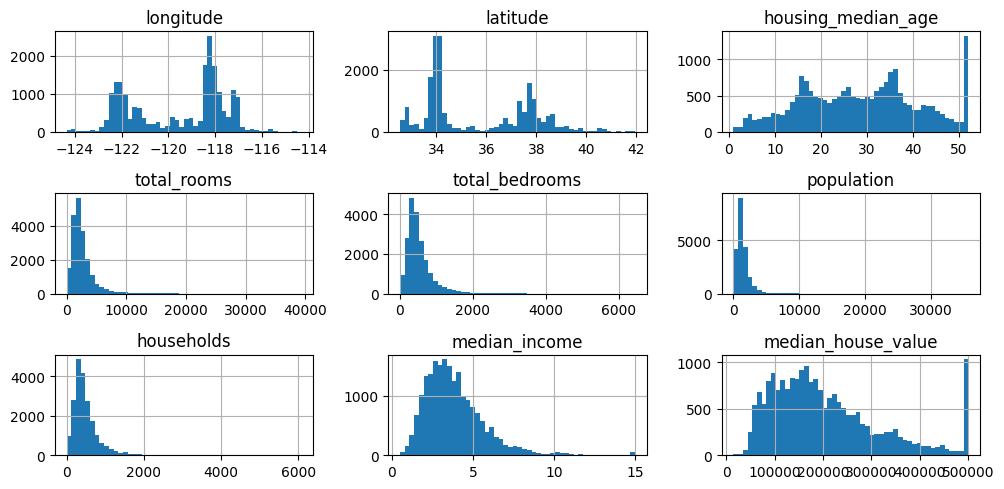

In [4]:
# TODO: 히스토그램을 그려보세요.
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(10,5))
plt.tight_layout() 
plt.show()

### TODO: max 값 확인하기 (아래 답안작성 필요)
Q1: 주택의 연식이 굉장히 오래됐을 때 어떤 수치로 기재했을까요?<br>
A1: 52

Q2: 주택 중위가격이 굉장히 높은 경우 어떤 수치로 기재했을까요?<br>
A2: 500001


우리는 median_house_value를 제외한 인자들을 입력으로 받아 median_house_value를 예측하는 인공신경망을 만들 것입니다.

## 데이터 그려보기

경도와 위도가 있으니 그림을 그려봅시다.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='longitude', ylabel='latitude'>

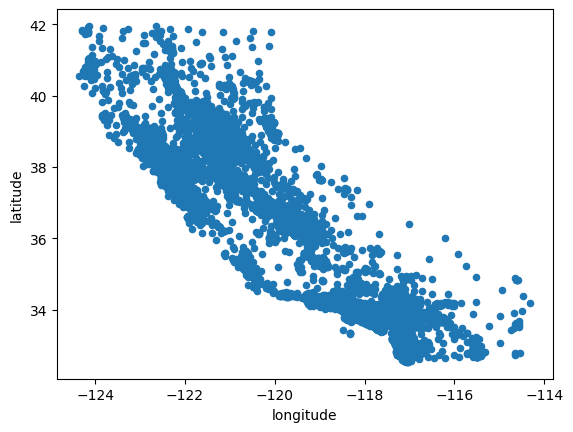

In [5]:
# TODO: 경도와 위도를 사용하여 점 찍어보기
# Hint: housing 인자 중 경도에 해당하는 컬럼 이름을 x에 기재하고, 위도에 해당하는 컬럼 이름을 y에 기재합니다. 
housing.plot(kind="scatter", x="longitude", y="latitude")

점이 많이 찍힌 곳과 적게 찍힌 곳을 구분하기 위해 투명도를 설정해 봅시다.

<Axes: xlabel='longitude', ylabel='latitude'>

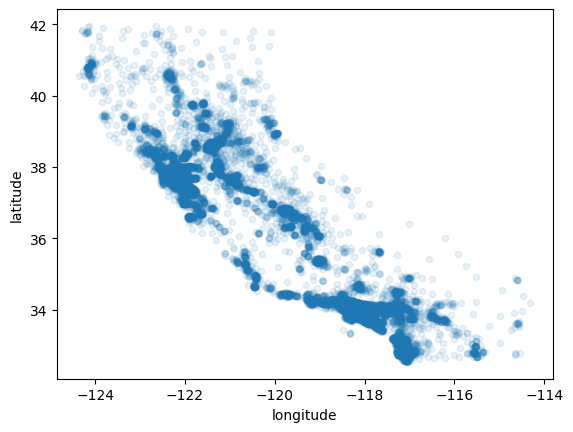

In [6]:
# TODO: 적절한 alpha 값 (0~1)으로 그려보세요.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

점의 크기는 인구/100에 비례하도록, 점의 색상은 중위 주택가격에 따라 다르게 그려봅시다.

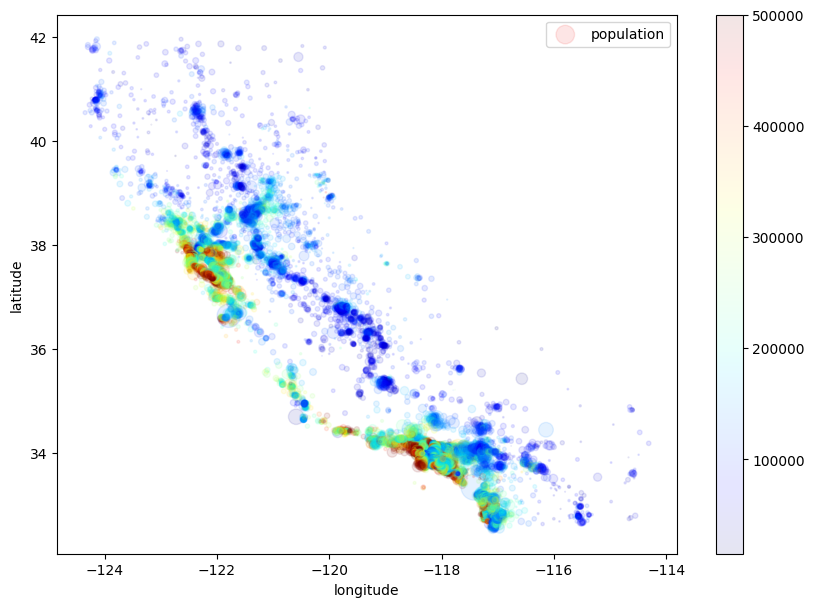

In [7]:
# TODO: 크기는 s, 색상은 c에 기재하고, 컬러맵은 원하는 것을 기재합니다. (고민되면 "jet" 기재)
# 컬러맵 참조: https://matplotlib.org/stable/tutorials/colors/colormaps.html

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [8]:
# 캘리포니아 지도 다운로드하기, 이해하지 않아도 괜찮습니다.
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join('.', filename))

('./california.png', <http.client.HTTPMessage at 0x7feecb921e50>)

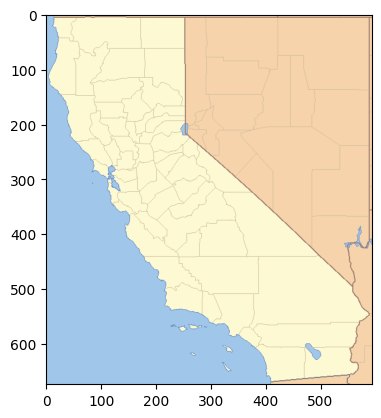

In [9]:
# 다운받은 그림 그려보기, 이해하지 않아도 괜찮습니다.
import matplotlib.image as mpimg
img = mpimg.imread('california.png')
plt.imshow(img)
plt.show()

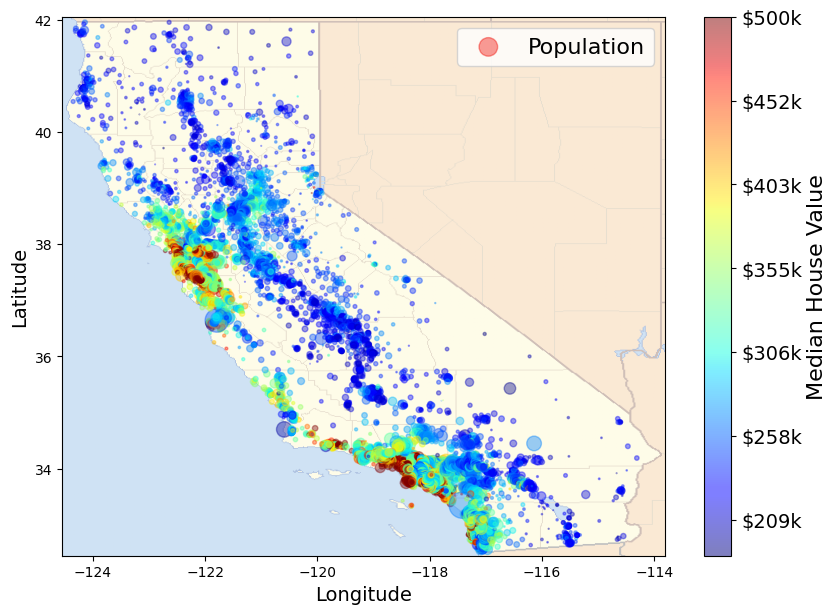

In [10]:
# 지도 위에 그림 그리기, 이해하지 않아도 괜찮습니다.
import matplotlib.image as mpimg
california_img=mpimg.imread('california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

해안가에 위치한 San Francisco, Los Angeles, San Diego 등의 주택가격이 높은 것을 확인 할 수 있습니다.

## 데이터 정제하기

기계학습에서 알 수 없는 값인 null이 있는 경우 문제가 될 수 있습니다. null이 얼마 없는 경우 null을 포함한 데이터를 제외하면 되고, 많다면 중간값 혹은 평균값 등을 입력하는 방법을 생각해볼 수도 있습니다.

In [11]:
# TODO: 각 컬럼의 데이터 타입과 null 값을 지닌 컬럼이 있는지 확인해보세요.
# Hint: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
# null값이 있는 샘플들을 지웁니다.
housing = housing.dropna(subset=["total_bedrooms"]) 
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [13]:
# TODO: ocean_proximity에 어떤 값들이 있는지 알아봅시다.
# Hint: https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html
ocean_proximity_counts = housing['ocean_proximity'].value_counts()
print(ocean_proximity_counts)


<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64


인공 신경망에는 ocean_proximity에 기재된 string이 입력될 수 없으므로 숫자로 변환해야 합니다.

## 원핫 인코딩 적용
텍스트가 기재된 ocean_proximity 대신 5개의 어트리뷰트를 사용하여 ocean_proximity 값이 어느 카테고리에 속하는지를 표시합니다.

In [14]:
# Pandas의 함수를 사용하여 원핫 인코딩을 적용합시다.
housing = pd.get_dummies(housing)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20433 non-null  float64
 1   latitude                    20433 non-null  float64
 2   housing_median_age          20433 non-null  float64
 3   total_rooms                 20433 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20433 non-null  float64
 6   households                  20433 non-null  float64
 7   median_income               20433 non-null  float64
 8   median_house_value          20433 non-null  float64
 9   ocean_proximity_<1H OCEAN   20433 non-null  uint8  
 10  ocean_proximity_INLAND      20433 non-null  uint8  
 11  ocean_proximity_ISLAND      20433 non-null  uint8  
 12  ocean_proximity_NEAR BAY    20433 non-null  uint8  
 13  ocean_proximity_NEAR OCEAN  204

In [17]:
# TODO: 무작위로 10개의 샘플을 표시하여 원핫 인코딩을 확인해보세요.
print(housing.head(10))

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value  \
0       322.0       126.0         8.3252            452600.0   
1      2401.0      1138.0         8.3014      

## 훈련 데이터, 검증 데이터, 테스트 데이터로 나누기
1. 훈련 데이터: 모델을 훈련할 때 직접적으로 사용
2. 검증 데이터: 모델을 훈련할 때 간접적으로 사용
3. 테스트 데이터: 훈련이 끝난 모델의 성능을 평가할 때 사용

일반적으로 훈련 (60%), 검증 (20%), 테스트 (20%)로 나눕니다. <br>
훈련 (80%), 테스트 (20%)로 나눈 후 훈련을 다시 훈련 (80%)과 검증 (20%)으로 나누기도 합니다.<br>

모두 같은 결과를 얻기 위해 train_test_split 함수에 random_state 42를 사용합니다.<br>
42는 '은하수를 여행하는 히치하이커를 위한 안내서'에 등장한 숫자입니다.

In [18]:
from sklearn.model_selection import train_test_split

# TODO
train, test = train_test_split(housing, test_size=0.2, random_state=42)

## X값과 y값 나누기
지도 학습에서는 데이터 (X)와 답 (y)을 분리하여 모델에 넣어줍니다.

In [20]:
# TODO
train_X = train.drop('median_house_value', axis=1)
train_y = train['median_house_value']
test_X = test.drop('median_house_value', axis=1)
test_y = test['median_house_value']
train_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17727,-121.80,37.32,14.0,4412.0,924.0,2698.0,891.0,4.7027,1,0,0,0,0
2057,-119.63,36.64,33.0,1036.0,181.0,620.0,174.0,3.4107,0,1,0,0,0
6453,-118.06,34.12,25.0,3891.0,848.0,1848.0,759.0,3.6639,0,1,0,0,0
4619,-118.31,34.07,28.0,2362.0,949.0,2759.0,894.0,2.2364,1,0,0,0,0
15266,-117.27,33.04,27.0,1839.0,392.0,1302.0,404.0,3.5500,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11397,-117.97,33.72,24.0,2991.0,500.0,1437.0,453.0,5.4286,1,0,0,0,0
12081,-117.54,33.76,5.0,5846.0,1035.0,3258.0,1001.0,4.7965,1,0,0,0,0
5447,-118.42,34.01,42.0,1594.0,369.0,952.0,362.0,3.0990,1,0,0,0,0
866,-122.04,37.57,12.0,5719.0,1064.0,3436.0,1057.0,5.2879,0,0,0,1,0


## 전처리 하기
Min-max normalization으로 모든 인자의 값을 0과 1사이의 값으로 변환합니다. <br>(https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization))<br>
**(중요) 모든 전처리 기법은 훈련 데이터만 사용하여 학습한 후 다른 데이터 (검증 및 테스트)에 적용합니다.**

In [21]:
# TODO
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [22]:
# 잘 변환됐는지 확인
import numpy as np

print(train_X.min()) 
print(train_X.max())

0.0
1.0


## 모델 만들기
MLP에서 숨겨진 층의 노드 개수는 입력층의 2/3 정도로 설정하는 것이 일반적이지만 최적이 아닐 수도 있으니 직접 실험을 해가며 설정하는 것이 좋습니다.

In [23]:
# 입력 데이터의 모양
train_X.shape

(16346, 13)

In [24]:
from keras import models
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(layers.Input(shape=(13,))) # 입력층의 모양은?
# TODO: 은닉층 자유롭게 설정
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear')) # 하나의 실수값을 출력합니다, 회귀의 활성화 함수는 linear를 사용합니다.

In [31]:
# TODO: 컴파일하기
# 회귀 문제에서는 loss에 mean_squred_error (MSE)를 사용합니다.
# MSE는 하나의 예측이 정답에서 얼마나 벗어났는지 평균 제곱 오차로 알려줍니다.
# 성능평가지표로는 MSE에 루트를 씌운 RMSE를 사용합니다. (동일하게 MSE로 사용해도 되나 RMSE 값 해석이 더 용이함)
# RMSE가 10이면 예측값과 실제값에 보통 10 정도의 차이가 있음을 의미합니다.
from tensorflow.keras import optimizers
model.compile(optimizer="Adam", loss='mean_squared_error', metrics=[metrics.RootMeanSquaredError(name='rmse')])

## 모델 훈련하기
훈련 데이터를 사용하여 인공신경망의 가중치를 조절합니다. 한 epoch이 끝나면 (훈련 데이터를 완전히 한 번 보고나면) 검증 데이터의 loss를 측정합니다. 훈련 데이터의 loss는 줄어드는데 검증 데이터의 loss가 증가하면 과적합이 일어나는 신호이므로 훈련을 중단합니다.<br>
**참고: 선형회귀 모델은 쉽게 7만 2천대의 RMSE를 달성했습니다. (예측한 주택가격이 실제가격과 7만 2천불 정도 차이가 남)**<br>
Optimizer에 따라 시간이 꽤 오래 걸릴 수 있으니 **시간이 부족하면 적당한 시점에 중단**하세요.

Iris 데이터셋이나 이 노트북에서 사용한 데이터셋과 같이 테이블 형태로 표현되는 데이터셋에서는 인공 신경망보다 결정 트리 모델이나 SVM과 같은 전통적인 기계학습 기법들이 더 뛰어난 성능을 보이는 경우가 많습니다.

In [32]:
model.fit(train_X, train_y, batch_size=256, epochs=10000, 
            callbacks=EarlyStopping(monitor='val_loss', patience=3),                                   # TODO: 과적합을 방지하는 콜백함수를 사용하세요.
            validation_split=0.2)                         # TODO: 훈련 데이터의 20%를 검증 데이터로 사용합니다.

Epoch 1/10000
52/52 [==============================] - 1s 6ms/step - loss: 50430246912.0000 - rmse: 224566.7969 - val_loss: 50966749184.0000 - val_rmse: 225758.1719
Epoch 2/10000
52/52 [==============================] - 0s 4ms/step - loss: 50398187520.0000 - rmse: 224495.4062 - val_loss: 50934611968.0000 - val_rmse: 225686.9844
Epoch 3/10000
52/52 [==============================] - 0s 4ms/step - loss: 50366119936.0000 - rmse: 224423.9688 - val_loss: 50902339584.0000 - val_rmse: 225615.4688
Epoch 4/10000
52/52 [==============================] - 0s 4ms/step - loss: 50333786112.0000 - rmse: 224351.9219 - val_loss: 50869956608.0000 - val_rmse: 225543.6875
Epoch 5/10000
52/52 [==============================] - 0s 4ms/step - loss: 50301366272.0000 - rmse: 224279.6562 - val_loss: 50837463040.0000 - val_rmse: 225471.6406
Epoch 6/10000
52/52 [==============================] - 0s 4ms/step - loss: 50268893184.0000 - rmse: 224207.2500 - val_loss: 50804850688.0000 - val_rmse: 225399.3125
Epoch 7/10

KeyboardInterrupt: ignored

## 테스트 데이터로 모델 평가하기
결과가 좋지 않아도 괜찮습니다.

In [33]:
# TODO: 훈련한 모델을 테스트 데이터로 평가하세요. (훈련을 중간에 중단해도 평가는 가능합니다.)
# Hint: https://keras.io/api/models/model_training_apis/#evaluate-method
model.evaluate(test_X, test_y)

128/128 [==============================] - 0s 2ms/step - loss: 23058583552.0000 - rmse: 151850.5312


[23058583552.0, 151850.53125]